In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicting-fraud-for-mobile-payment-services/paysim.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:


df = pd.read_csv('/kaggle/input/predicting-fraud-for-mobile-payment-services/paysim.csv'
)
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())



   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


## Exploratory Data Analysis

In [5]:
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldBalanceOrig    float64
newBalanceOrig    float64
nameDest           object
oldBalanceDest    float64
newBalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [7]:
df.isna().any()

step              False
type              False
amount            False
nameOrig          False
oldBalanceOrig    False
newBalanceOrig    False
nameDest          False
oldBalanceDest    False
newBalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

So, data has no null values and it has all numerical features.

In [8]:
df.shape

(6362620, 11)

In [9]:
df.columns


Index(['step', 'type', 'amount', 'nameOrig', 'oldBalanceOrig',
       'newBalanceOrig', 'nameDest', 'oldBalanceDest', 'newBalanceDest',
       'isFraud', 'isFlaggedFraud'],
      dtype='object')

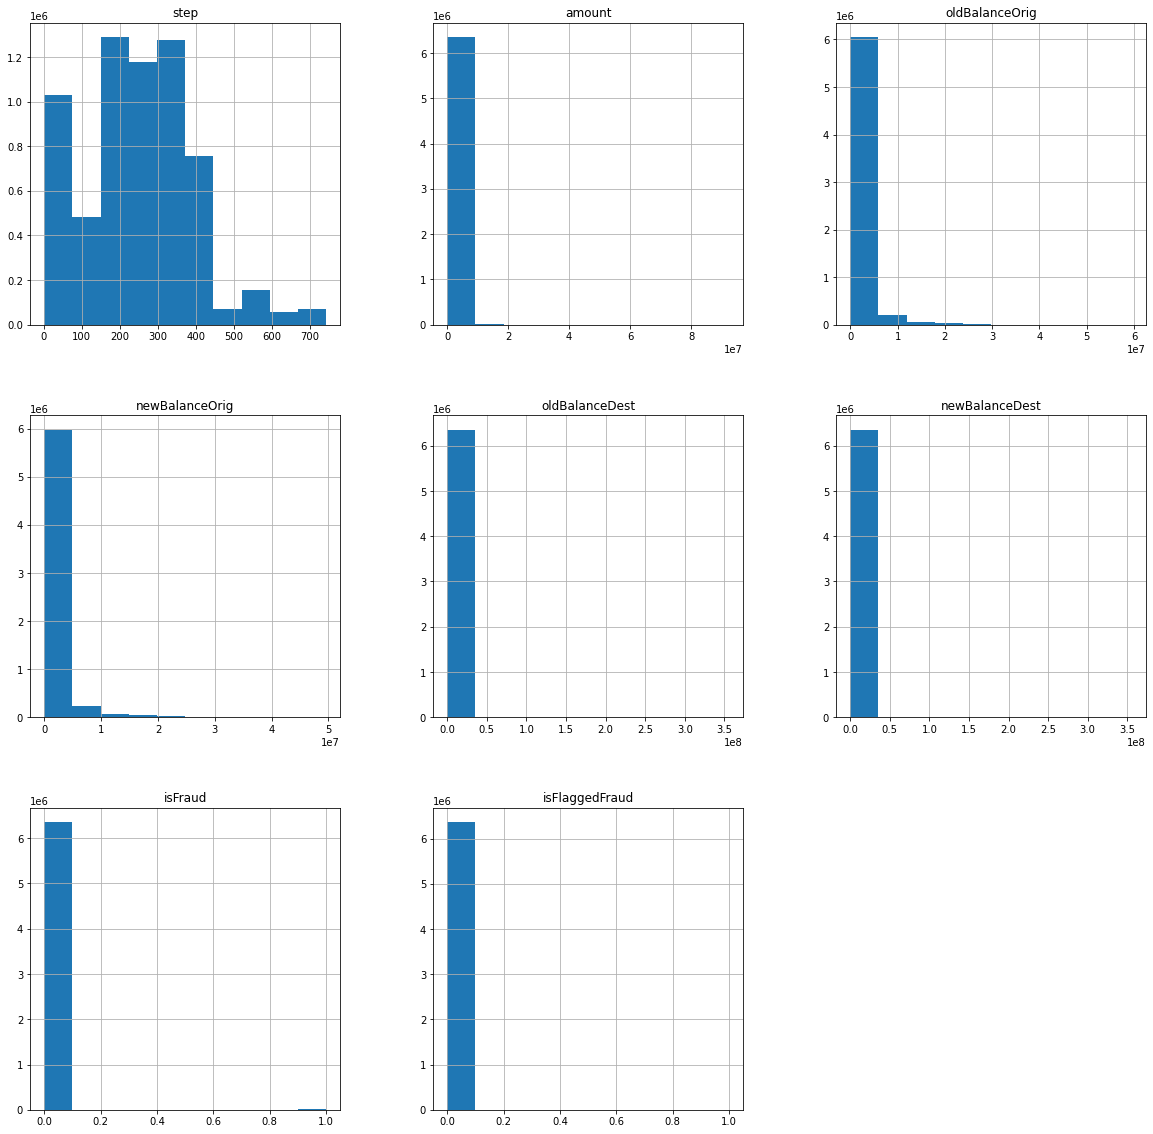

In [10]:
df.hist(figsize=(20,20))
plt.show()

Data is not widely spreaded. Even the transaction amount is not that large.


Number of fraudulent transactions  8213 , ( 0.12908204481801522 %)
Number of transactions which are not fraudulent 6354407 , ( 99.87091795518198 %)


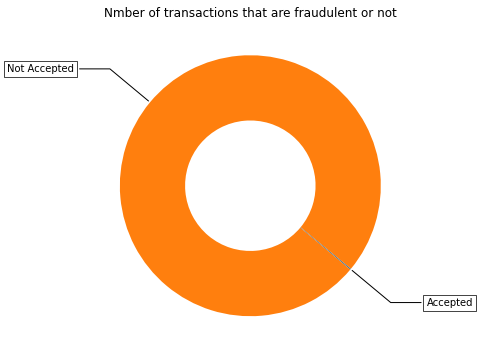

In [11]:
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


y_value_counts = df['isFraud'].value_counts()
print("Number of fraudulent transactions ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of transactions which are not fraudulent", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of transactions that are fraudulent or not")

plt.show()

In [12]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) # 4116


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


In [13]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(df.groupby("nameOrig")["isFraud"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['orig_code', 'num_transaction']

# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['num_transaction'], inplace=True)
print("Orig with lowest % frauds")
print(temp.head(5))
print('='*50)
print("Orig with highest % frauds")
print(temp.tail(5))


Orig with lowest % frauds
           orig_code  num_transaction
0        C1000000639              0.0
4234148    C35564544              0.0
4234147   C355645002              0.0
4234146   C355644953              0.0
4234145   C355644916              0.0
Orig with highest % frauds
           orig_code  num_transaction
4228711   C353964501              1.0
5272163   C671195185              1.0
4033643   C294300042              1.0
5694740   C799430524              1.0
2874070  C1874877556              1.0


In [14]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(df.groupby("type")["isFraud"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['type_code', 'num_transaction']

# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['num_transaction'], inplace=True)
print("Orig with lowest % frauds")
print(temp.head(5))
print('='*50)
print("Orig with highest % frauds")
print(temp.tail(5))


Orig with lowest % frauds
  type_code  num_transaction
0   CASH_IN         0.000000
2     DEBIT         0.000000
3   PAYMENT         0.000000
1  CASH_OUT         0.001840
4  TRANSFER         0.007688
Orig with highest % frauds
  type_code  num_transaction
0   CASH_IN         0.000000
2     DEBIT         0.000000
3   PAYMENT         0.000000
1  CASH_OUT         0.001840
4  TRANSFER         0.007688


We find that of the five types of transactions, fraud occurs only in two of them  'TRANSFER' where money is sent to a customer / fraudster and 'CASH_OUT' where money is sent to a merchant who pays the customer / fraudster in cash. Remarkably, the number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs.

In [15]:


print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                            # only 'TRANSFER'

dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min())) # 353874.22

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) # 92445516.64




The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


It turns out that the origin of isFlaggedFraud is unclear, contrasting with the description provided. The 16 entries (out of 6 million) where the isFlaggedFraud feature is set do not seem to correlate with any explanatory variable. The data is described as isFlaggedFraud being set when an attempt is made to 'TRANSFER' an 'amount' greater than 200,000. 

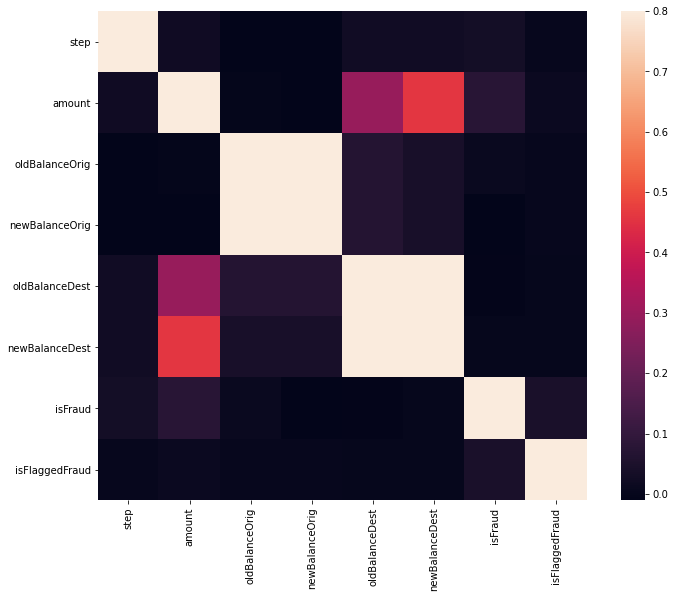

In [16]:
correlation_matrix = df.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

None of the features are closely related except few of the features.

In [17]:
print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: {}'.\
format([round(dfFlagged.oldBalanceOrig.min()), round(dfFlagged.oldBalanceOrig.max())]))

print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where \
oldBalanceOrig = \
newBalanceOrig: {}'.format(\
[dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
== dfTransfer.newBalanceOrig)].oldBalanceOrig.min(), \
round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
               == dfTransfer.newBalanceOrig)].oldBalanceOrig.max())]))


Min, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: [353874, 19585040]

Min, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where oldBalanceOrig = newBalanceOrig: [0.0, 575668]


In [19]:


print('\nWithin fraudulent transactions, are there destinations for TRANSFERS \
that are also originators for CASH_OUTs? {}'.format(\
(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any())) # False
dfNotFraud = df.loc[df.isFraud == 0]




Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? False


In [20]:


print('\nFraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))




Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

         step      type      amount     nameOrig  oldBalanceOrig  \
1030443    65  TRANSFER  1282971.57  C1175896731      1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649       214793.32   
6362556   738  TRANSFER   814689.88  C2029041842       814689.88   

         newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


## Data cleaning

In [21]:


X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)





The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted. The fraction of such transactions, where zero likely denotes a missing value, is much larger in fraudulent (50%) compared to genuine transactions (0.06%).


In [22]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


In [23]:


X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan



In [24]:


X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1



## Feature-engineering

In [25]:


X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest



These new features turn out to be important in obtaining the best performance from the ML algorithm that we will finally use.

## Data visualization

In [26]:


limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax



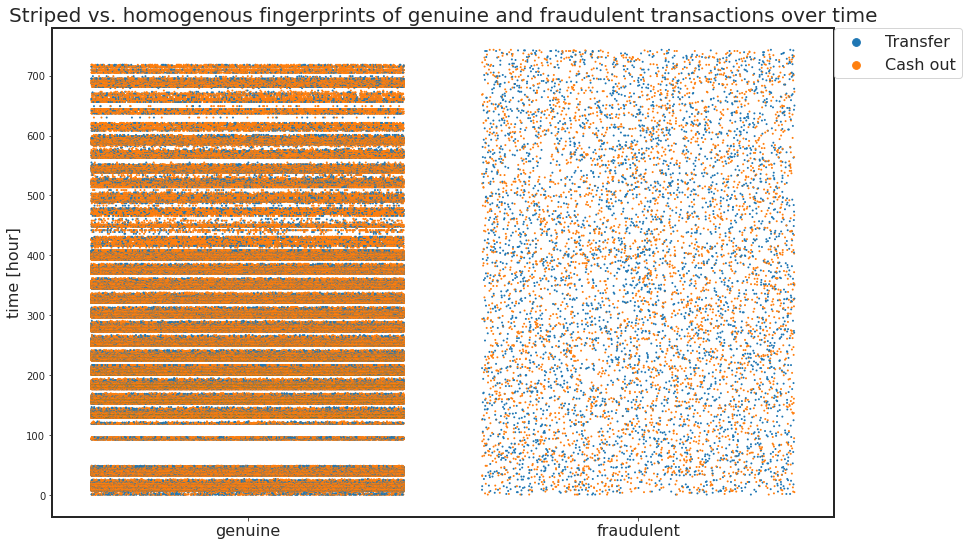

In [27]:


ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);



The plot above shows how the fraudulent and genuine transactions yield different fingerprints when their dispersion is viewed over time. It is clear that fradulent transactions are more homogenously distributed over time compared to genuine transactions. Also apparent is that CASH-OUTs outnumber TRANSFERs in genuine transactions, in contrast to a balanced distribution between them in fraudulent transactions


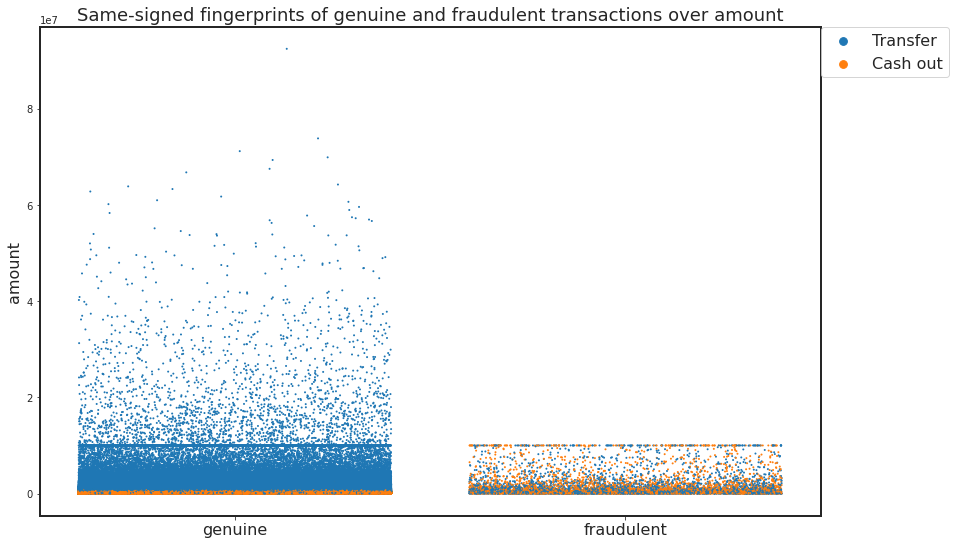

In [28]:


limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);



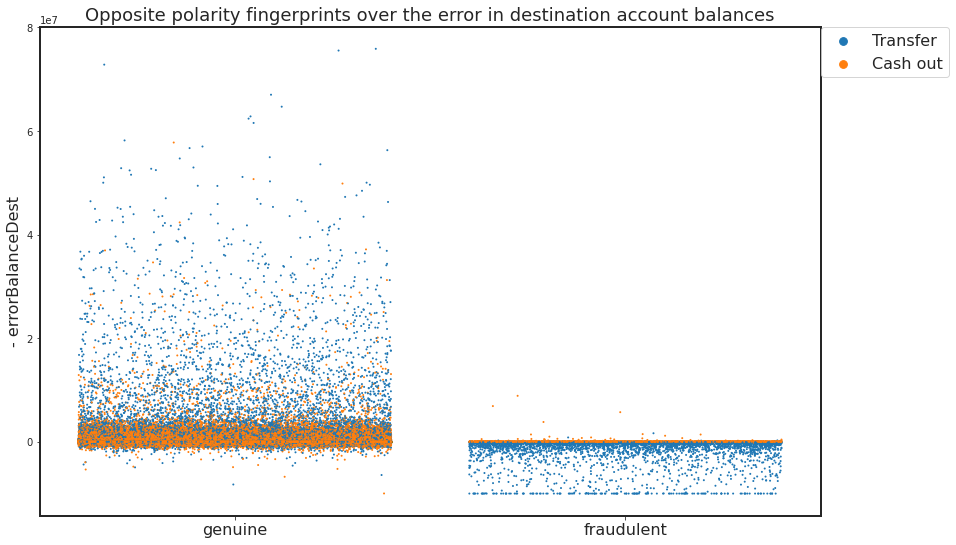

In [30]:


limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);



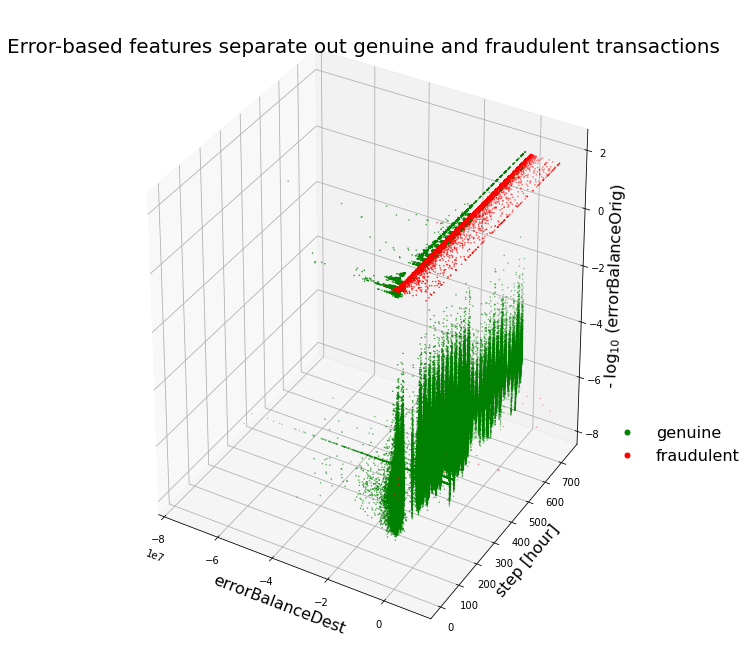

In [31]:
# Long computation in this cell (~2.5 minutes)
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});



The two plots above shows that although the presence of fraud in a transaction can be discerned by the original amount feature, the new errorBalanceDest feature is more effective at making a distinction.
**

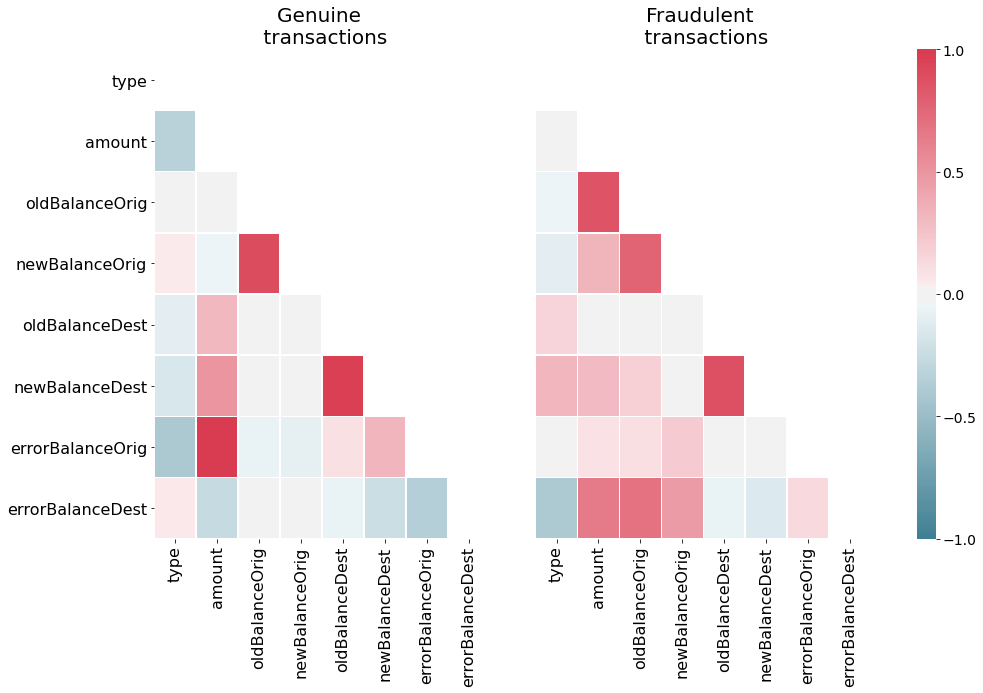

In [29]:


Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud 
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);



In [32]:


print('skew = {}'.format( len(Xfraud) / float(len(X)) ))



skew = 0.002964544224336551


In [33]:


trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)



In [34]:


# Long computation in this cell (~1.8 minutes)
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))



AUPRC = 0.9983642588456604


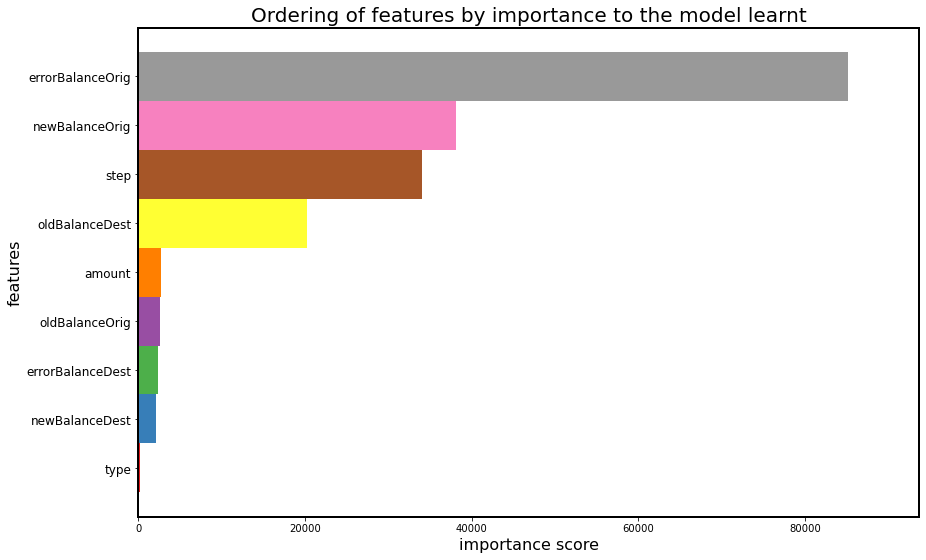

In [35]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);